 # Описание проекта

Задача – разработать модель многоклассовой классификации, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока. Оценить модель при помощи precision, recall, f1_score, accuracy.


# Импорт библиотек

In [3]:
pip install skimpy catboost optuna --quiet

In [4]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import seaborn as sns
import catboost
import time
import optuna

from sklearn.model_selection import (train_test_split, RandomizedSearchCV, cross_val_score)
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import (accuracy_score, make_scorer, precision_score, recall_score, f1_score,
                             classification_report)
from skimpy import skim, clean_columns
from sklearn.preprocessing import (LabelEncoder, StandardScaler)
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from concurrent.futures import ThreadPoolExecutor

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

# Предобработка данных

Загрузим и изучим данные.

In [6]:
try:
    data = pd.read_csv('/content/network_traffic_data.csv')
except:
    print('Try a differernt path')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

Единственный категориальный признак – целевой признак "Label".

In [8]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
438301,80,13350,2,2,12,0,6,6,6.00,0.000,0,0,0.0,0.0,8.988764e+02,299.625468,4.450000e+03,7.302734e+03,12879,26,471,471.0,0.000000e+00,471,471,13324,13324.00,0.000000e+00,13324,13324,0,0,0,0,40,64,149.812730,149.812730,0,6,3.600,3.287,1.080000e+01,1,0,0,0,0,0,0,0,1,4.500,6.00,0.0,40,0,0,0,0,0,0,2,12,2,0,0,235,1,20,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
344028,80,85864914,9,5,368,11595,368,0,40.88,122.700,4344,0,2320.0,2196.0,1.393235e+02,0.163047,6.604994e+06,2.380000e+07,85700000,5,85700000,10700000.0,3.030000e+07,85700000,5,146467,36616.75,6.406176e+04,132207,63,0,0,0,0,296,168,0.104816,0.058231,0,4344,797.500,1621.000,2.627561e+06,0,0,0,0,1,0,0,0,0,854.500,40.88,2320.0,296,0,0,0,0,0,0,9,368,5,11595,251,235,1,32,2773.0,0.0,2773,2773,85700000.0,0.0,85700000,85700000,DoS Hulk
468267,80,98374742,6,7,356,11595,338,0,59.34,136.500,5792,0,1656.0,2120.0,1.214844e+02,0.132148,8.197895e+06,2.840000e+07,98300000,1,98400000,19700000.0,4.400000e+07,98300000,1,98400000,16400000.00,4.020000e+07,98400000,45,0,0,0,0,164,232,0.060991,0.071156,0,5792,854.000,1666.000,2.776429e+06,1,0,0,0,0,0,0,0,1,920.000,59.34,1656.0,164,0,0,0,0,0,0,6,356,7,11595,0,235,3,20,10997.0,0.0,10997,10997,98300000.0,0.0,98300000,98300000,DoS Hulk
354860,80,72123344,8,4,56,11601,20,0,7.00,5.656,7215,0,2900.0,3540.0,1.616259e+02,0.166382,6.556668e+06,1.810000e+07,60200000,1,71100000,10200000.0,2.240000e+07,60200000,1,1025279,341759.66,5.814590e+05,1013136,159,0,0,0,0,172,92,0.110921,0.055461,0,7215,897.000,2250.000,5.064818e+06,0,0,0,0,1,0,0,0,0,972.000,7.00,2900.0,172,0,0,0,0,0,0,8,56,4,11601,256,229,6,20,3.0,0.0,3,3,35500000.0,34900000.0,60200000,10900000,DDoS
508040,21,4,2,0,14,0,14,0,7.00,9.900,0,0,0.0,0.0,3.500000e+06,500000.000000,4.000000e+00,0.000000e+00,4,4,4,4.0,0.000000e+00,4,4,0,0.00,0.000000e+00,0,0,1,0,0,0,64,0,500000.000000,0.000000,0,14,9.336,8.086,6.533334e+01,0,1,0,0,1,0,0,0,0,14.000,7.00,0.0,64,0,0,0,0,0,0,2,14,0,0,229,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,FTP-Patator
164563,53,205,2,2,94,196,47,47,47.00,0.000,98,98,98.0,0.0,1.414634e+06,19512.195120,6.833334e+01,3.521836e+01,109,48,48,48.0,0.000000e+00,48,48,48,48.00,0.000000e+00,48,48,0,0,0,0,40,40,9756.098000,9756.098000,47,98,67.400,27.940,7.803000e+02,0,0,0,0,0,0,0,0,1,84.250,47.00,98.0,40,0,0,0,0,0,0,2,94,2,196,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
82988,443,101317,3,0,0,0,0,0,0.00,0.000,0,0,0.0,0.0,0.000000e+00,29.610036,5.065850e+04,1.201869e+04,59157,42160,101317,50658.5,1.201869e+04,59157,42160,0,0.00,0.000000e+00,0,0,0,0,0,0,96,0,29.610035,0.000000,0,0,0.000,0.000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000,0.00,0.0,96,0,0,0,0,0,0,3,0,0,0,326,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
534905,80,8705089,2,0,0,0,0,0,0.00,0.0

Посмотрим на классы в целевом признаке.

In [9]:
data.Label.unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

In [10]:
# очистим приведем названия столбцов к snake_case для удобства
data = clean_columns(data)
data.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [11]:
# проверим наличие пропусков
data.isna().mean()

destination_port               0.000000
flow_duration                  0.000000
total_fwd_packets              0.000000
total_backward_packets         0.000000
total_length_of_fwd_packets    0.000000
total_length_of_bwd_packets    0.000000
fwd_packet_length_max          0.000000
fwd_packet_length_min          0.000000
fwd_packet_length_mean         0.000000
fwd_packet_length_std          0.000000
bwd_packet_length_max          0.000000
bwd_packet_length_min          0.000000
bwd_packet_length_mean         0.000000
bwd_packet_length_std          0.000000
flow_bytes_s                   0.000904
flow_packets_s                 0.000000
flow_iat_mean                  0.000000
flow_iat_std                   0.000000
flow_iat_max                   0.000000
flow_iat_min                   0.000000
fwd_iat_total                  0.000000
fwd_iat_mean                   0.000000
fwd_iat_std                    0.000000
fwd_iat_max                    0.000000
fwd_iat_min                    0.000000


In [12]:
# удалим пропуски, т.к. их мало
data.dropna(inplace=True)
data.isna().mean()

destination_port               0.0
flow_duration                  0.0
total_fwd_packets              0.0
total_backward_packets         0.0
total_length_of_fwd_packets    0.0
total_length_of_bwd_packets    0.0
fwd_packet_length_max          0.0
fwd_packet_length_min          0.0
fwd_packet_length_mean         0.0
fwd_packet_length_std          0.0
bwd_packet_length_max          0.0
bwd_packet_length_min          0.0
bwd_packet_length_mean         0.0
bwd_packet_length_std          0.0
flow_bytes_s                   0.0
flow_packets_s                 0.0
flow_iat_mean                  0.0
flow_iat_std                   0.0
flow_iat_max                   0.0
flow_iat_min                   0.0
fwd_iat_total                  0.0
fwd_iat_mean                   0.0
fwd_iat_std                    0.0
fwd_iat_max                    0.0
fwd_iat_min                    0.0
bwd_iat_total                  0.0
bwd_iat_mean                   0.0
bwd_iat_std                    0.0
bwd_iat_max         

In [13]:
# проверим данные на дубликаты
data.duplicated().sum()

64153

In [14]:
data[data.duplicated(keep='first')].sample(20)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_s,flow_packets_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_s,bwd_packets_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length_1,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
324214,8099,54,1,1,2,6,2,2,2.0,0.0,6,6,6.0,0.0,1.481481e+05,37037.03704,54.000000,0.000000,54,54,0,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0,0,0,24,20,18518.518,18518.5180,2,6,3.334,2.309,5.333334,0,0,0,1,0,0,0,0,1,5.000,2.0,6.0,24,0,0,0,0,0,0,1,2,1,6,1024,0,0,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
359430,4449,43,1,1,0,6,0,0,0.0,0.0,6,6,6.0,0.0,1.395349e+05,46511.62791,43.000000,0.000000,43,43,0,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0,0,0,40,20,23255.814,23255.8140,0,6,2.000,3.465,12.000000,0,0,0,1,0,0,0,0,1,3.000,0.0,6.0,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
266369,80,3,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,666666.66670,3.000000,0.000000,3,3,3,3.000000,0.000000,3,3,0,0.0,0.0,0,0,0,0,0,0,64,0,666666.700,0.0000,0,0,0.000,0.000,0.000000,0,0,0,0,1,0,0,0,0,0.000,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
507665,21,221,2,1,14,0,14,0,7.0,9.9,0,0,0.0,0.0,6.334842e+04,13574.66063,110.500000,57.275650,151,70,221,221.000000,0.000000,221,221,0,0.0,0.0,0,0,1,0,0,0,64,20,9049.773,4524.8867,0,14,7.000,8.086,65.333336,0,1,0,0,1,0,0,0,0,9.336,7.0,0.0,64,0,0,0,0,0,0,2,14,1,0,229,0,0,32,0.0,0.0,0,0,0.0,0.0,0,0,FTP-Patator
431747,1121,43,1,1,2,6,2,2,2.0,0.0,6,6,6.0,0.0,1.860465e+05,46511.62791,43.000000,0.000000,43,43,0,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0,0,0,24,20,23255.814,23255.8140,2,6,3.334,2.309,5.333334,0,0,0,1,0,0,0,0,1,5.000,2.0,6.0,24,0,0,0,0,0,0,1,2,1,6,1024,0,0,24,0.0,0.0,0,0,0.0,0.0,0,0,PortScan
290436,80,4,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,500000.00000,4.000000,0.000000,4,4,4,4.000000,0.000000,4,4,0,0.0,0.0,0,0,0,0,0,0,64,0,500000.000,0.0000,0,0,0.000,0.000,0.000000,0,0,0,0,1,0,0,0,0,0.000,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
516013,22,47,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,42553.19149,47.000000,0.000000,47,47,0,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,0,0,0,32,32,21276.596,21276.5960,0,0,0.000,0.000,0.000000,0,0,0,0,1,1,0,0,1,0.000,0.0,0.0,32,0,0,0,0,0,0,1,0,1,0,259,247,0,32,0.0,0.0,0,0,0.0,0.0,0,0,SSH-Patator
371163,80,3,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,666666.66670,3.000000,0.000000,3,3,3,3.000000,0.000000,3,3,0,0.0,0.0,0,0,0,0,0,0,64,0,666666.700,0.0000,0,0,0.000,0.000,0.000000,0,0,0,0,1,0,0,0,0,0.000,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,251,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
435593,80,3,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,666666.66670,3.000000,0.000000,3,3,3,3.000000,0.000000,3,3,0,0.0,0.0,0,0,0,0,0,0,64,0,666666.700,0.0000,0,0,0.000,0.000,0.000000,0,0,0,0,1,0,0,0,0,0.000,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,274,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS Hulk
288480,80,4,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.00000

Не будем удалять дубликаты, потому что полные совпадения в такого рода данных вероятны.

In [15]:
# округлим float-значения
data[data.select_dtypes(include=['float']).columns] = data.select_dtypes(include=['float']).round(2)
data.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_s,flow_packets_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_s,bwd_packets_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length_1,fwd_avg_bytes_bulk,fwd_avg_packets_bulk,fwd_avg_bulk_rate,bwd_avg_bytes_bulk,bwd_avg_packets_bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,80,5480074,3,1,12,0,6,0,4.00,3.46,0,0,0.0,0.0,2.19,0.73,1826691.40,3131700.20,5442804,101,5480074,2740037.00,3822289.80,5442804,37270,0,0.00,0.00,0,0,0,0,0,0,72,32,0.55,0.18,0,6,2.4,3.29,10.80,0,0,0,1,0,0,0,0,0,3.00,4.00,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.10,103.30,1448,0,395.0,587.5,6535.32,26.69,39554.28,50154.62,120501,1,616301,77037.62,72995.98,215614,230,616874,68541.55,71985.97,199836,1,0,0,0,0,296,328,12.64,14.05,0,1448,232.6,442.80,196012.66,0,0,0,1,0,0,0,0,1,244.90,78.10,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.00,0.00,112,112,112.0,0.0,1981.77,26.08,51132.67,88558.31,153391,3,3,3.00,0.00,3,3,4,4.00,0.00,4,4,0,0,0,0,40,40,13.04,13.04,40,112,68.8,39.44,1555.20,0,0,0,0,0,0,0,0,1,86.00,40.00,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.00,0.00,128,128,128.0,0.0,3017.69,34.69,57660.00,0.00,57660,57660,0,0.00,0.00,0,0,0,0.00,0.00,0,0,0,0,0,0,20,20,17.34,17.34,46,128,73.3,47.34,2241.33,0,0,0,0,0,0,0,0,1,110.00,46.00,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.34,14.44,6,6,6.0,0.0,63885.27,5215.12,255.67,394.29,710,3,713,356.50,499.92,710,3,0,0.00,0.00,0,0,0,0,0,0,60,20,3911.34,1303.78,6,31,11.0,11.18,125.00,0,0,0,0,1,0,0,0,0,13.75,14.34,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [16]:
# посчитаем количество "бесконечных" значений
inf_count = np.isinf(data.drop(columns=['label'], axis=1)).sum(axis=0)
inf_count

destination_port                 0
flow_duration                    0
total_fwd_packets                0
total_backward_packets           0
total_length_of_fwd_packets      0
total_length_of_bwd_packets      0
fwd_packet_length_max            0
fwd_packet_length_min            0
fwd_packet_length_mean           0
fwd_packet_length_std            0
bwd_packet_length_max            0
bwd_packet_length_min            0
bwd_packet_length_mean           0
bwd_packet_length_std            0
flow_bytes_s                   246
flow_packets_s                 246
flow_iat_mean                    0
flow_iat_std                     0
flow_iat_max                     0
flow_iat_min                     0
fwd_iat_total                    0
fwd_iat_mean                     0
fwd_iat_std                      0
fwd_iat_max                      0
fwd_iat_min                      0
bwd_iat_total                    0
bwd_iat_mean                     0
bwd_iat_std                      0
bwd_iat_max         

In [17]:
# заменяем бесконечные значения максимумом по столбцу
for column in ['flow_bytes_s','flow_packets_s']:
    max_finite_value = np.max(np.isfinite(data[column]))
    data[column].replace([np.inf, -np.inf], max_finite_value, inplace=True)

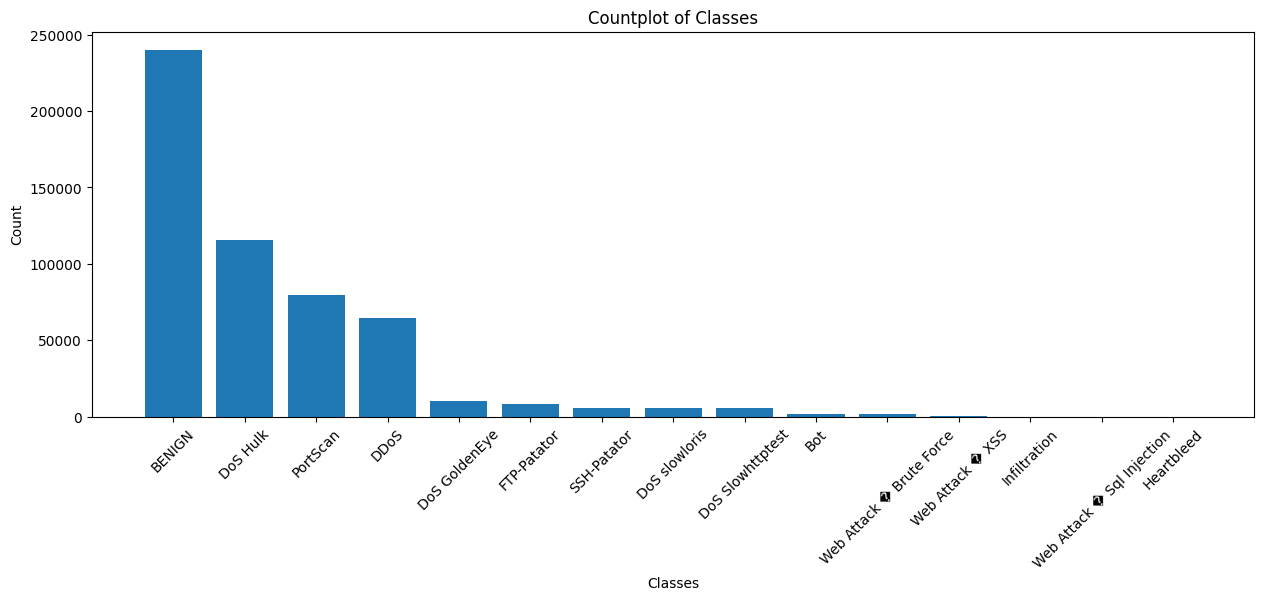

In [18]:
# посмотрим на соотношение классов в целевой переменной
counts = data['label'].value_counts()
plt.figure(figsize=(15, 5))
plt.bar(counts.index, counts.values)

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Countplot of Classes')

plt.xticks(rotation=45)
None

In [19]:
data.label.value_counts().sort_values()

label
Heartbleed                        11
Web Attack � Sql Injection        21
Infiltration                      36
Web Attack � XSS                 652
Web Attack � Brute Force        1507
Bot                             1966
DoS Slowhttptest                5499
DoS slowloris                   5796
SSH-Patator                     5897
FTP-Patator                     7938
DoS GoldenEye                  10293
DDoS                           64366
PortScan                       79660
DoS Hulk                      115527
BENIGN                        239959
Name: count, dtype: int64

Большинство трафика – нормальное, в злонамеренном преобладают (D)DoS-атаки и сканирование портов.

## Выводы


*   в этом разделе были очищены названия столбцов
*   удалены пропуски
*   округлили float-значения
*   заменили бесконечные значения максимумом по столбцу



# EDA

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

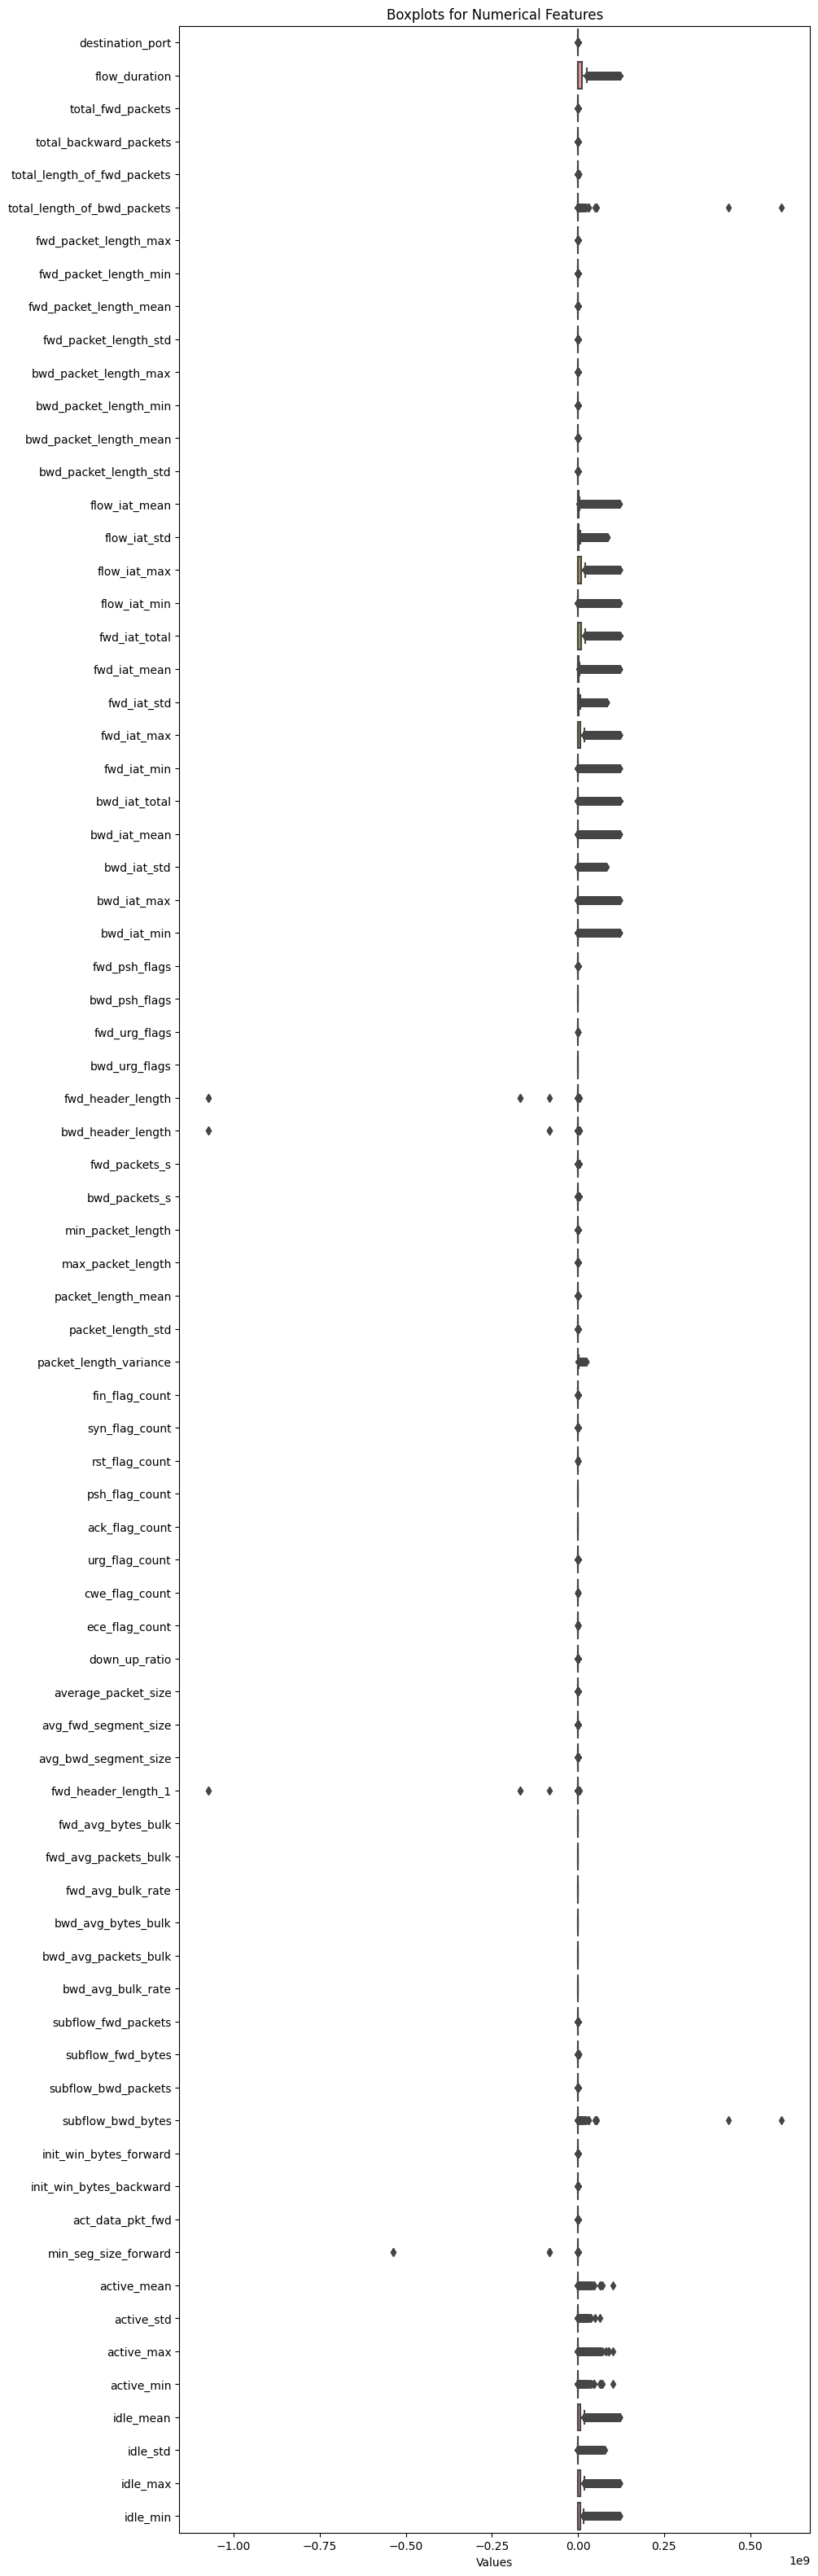

In [20]:
# распределение числовых данных
plt.figure(figsize=(10, 40))
sns.boxplot(data=data, orient='h')
plt.xlabel("Values")
plt.title("Boxplots for Numerical Features")
plt.show()
None

Видим явные выбросы в ряде столбцов.

In [21]:
# кодируем целевой признак
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])
data['encoded_label'] = label_encoder.transform(data['label'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [22]:
data.encoded_label.unique()

array([ 0, 10,  4,  2,  1,  9, 12, 14, 13,  7, 11,  6,  5,  3,  8])

In [23]:
print("Mapping of labels to integers:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Mapping of labels to integers: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


In [24]:
#функция подсчета корреляции для целевого признака
def corr_matrix(df, col):
    df.corr()[[col]].sort_values(by=col, ascending=False)
    plt.figure(figsize=(8, 20))
    heatmap = sns.heatmap(df.corr()[[col]].sort_values(by=col, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Features  сorrelating with '+col, fontdict={'fontsize':18}, pad=16);

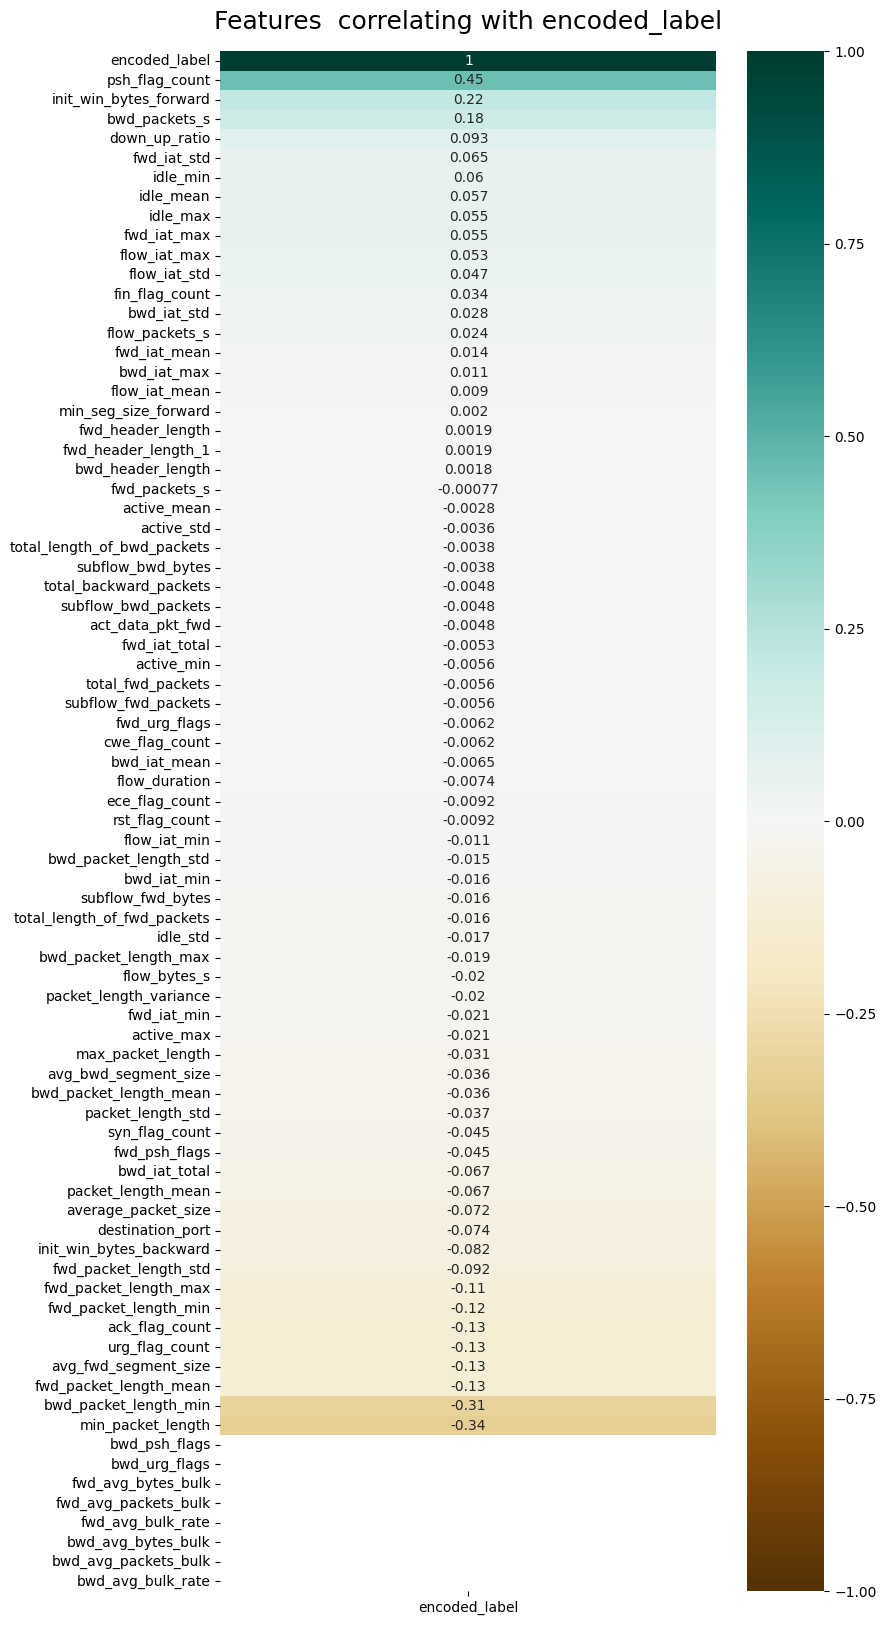

In [25]:
#посмотрим, какие признаки больше всего коррелируют с encoded_label
corr_matrix(data.drop(columns=['label'], axis=1), "encoded_label")

Видим, что наиболее значимая корреляция – с признаком psh_flag_count. Также видим, что большинство признаков обладают околонулевой корреляцией с целевым. Также в данных 8 столбцов, по которым отсутствуют значения корреляции.

In [26]:
# проверим значения в столбцах, для которых нет данных
cols = ['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk',
 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']

for col in cols:
    print(data[col].unique())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [27]:
# удалим эти столбцы за неинформативностью
data.drop(columns=cols, axis=1, inplace=True)

In [28]:
# удаляем encoded столбец
data.drop(columns=['encoded_label'], inplace=True)

In [29]:
# дополнительно отберем признаки по значимости с помощью SelectKBest
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(data.drop(columns=['label'], axis=1), data['label'])

feature_scores = selector.scores_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(

In [30]:
# сохраняем названия признаков
feature_names = list(data.drop(columns=['label'], axis=1).columns)

# объединяем названия с полученными весами
feature_scores_with_names = list(zip(feature_names, feature_scores))

# сортируем данные по убыванию
feature_scores_with_names.sort(key=lambda x: x[1], reverse=True)

print(f"Top features selected based on Mutual Information:")
for i, (feature_name, score) in enumerate(feature_scores_with_names):
    print(f"{i + 1}. Feature: {feature_name}, Mutual Information Score: {score}")

Top features selected based on Mutual Information:
1. Feature: average_packet_size, Mutual Information Score: 1.215078428542067
2. Feature: packet_length_mean, Mutual Information Score: 1.1749014350318756
3. Feature: packet_length_variance, Mutual Information Score: 1.1407627541980232
4. Feature: packet_length_std, Mutual Information Score: 1.1260640620369973
5. Feature: init_win_bytes_forward, Mutual Information Score: 1.0565288647364868
6. Feature: subflow_fwd_bytes, Mutual Information Score: 1.0323220080800615
7. Feature: total_length_of_bwd_packets, Mutual Information Score: 1.031469330168765
8. Feature: total_length_of_fwd_packets, Mutual Information Score: 1.0314571260060221
9. Feature: subflow_bwd_bytes, Mutual Information Score: 1.030996763009728
10. Feature: max_packet_length, Mutual Information Score: 1.0097638080756843
11. Feature: bwd_packet_length_mean, Mutual Information Score: 1.0089306272993628
12. Feature: avg_bwd_segment_size, Mutual Information Score: 1.0086973258540

In [31]:
# удалим признаки с весами меньше 0.2
selected_features = [(name, score) for name, score in feature_scores_with_names if score < 0.2]
features_to_remove = list(pd.DataFrame(selected_features)[0])
features_to_remove

['down_up_ratio',
 'ack_flag_count',
 'idle_std',
 'fin_flag_count',
 'urg_flag_count',
 'active_std',
 'fwd_psh_flags',
 'syn_flag_count',
 'cwe_flag_count',
 'ece_flag_count',
 'fwd_urg_flags',
 'rst_flag_count']

In [32]:
data.drop(columns=features_to_remove, axis=1, inplace=True)
data.shape

(539128, 59)

По результатам анализа корреляций и значимости признаков уменьшили размерность на 20 столбцов.

## Выводы


1.   в этом разделе изучили распределение числовых данных
2.   изучили корреляцию признаков
3.   проанализировали важность признаком при помощи SelectKBest
4.   отобрали признаки для обучающей выборки на основе анализа корреляции и результатов SelectKBest



# Подготовка данных к машинному обучению

In [33]:
# поделим данные
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['label'], axis=1),
                                                    data['label'], test_size=0.3, random_state=42)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(377389, 58)
(377389,)
(161739, 58)
(161739,)


(None, None)

In [34]:
# масштабируем данные с помощью StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

# Обучение моделей

## Logistic Regression (baseline)

Сделаем предсказания при помощи логистической регрессии с сбалансированными классами.


In [35]:
classifier = LogisticRegression(random_state=42, class_weight='balanced', max_iter=100)

start_time = time.time()

classifier.fit(X_train_scaled, y_train)

end_time = time.time()
execution_time = end_time - start_time

# Make predictions on the test set
y_pred = classifier.predict(X_test_scaled)

# Evaluate the model
report = classification_report(y_test, y_pred)

print("Fit time: ", execution_time)
print("Classification Report:\n", report)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

Fit time:  75.93019151687622
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      0.73      0.84     72076
                       Bot       0.07      0.81      0.14       605
                      DDoS       0.93      1.00      0.96     19314
             DoS GoldenEye       0.75      0.95      0.84      3122
                  DoS Hulk       0.98      0.86      0.92     34400
          DoS Slowhttptest       0.80      0.93      0.86      1668
             DoS slowloris       0.74      0.85      0.79      1766
               FTP-Patator       0.24      0.99      0.39      2409
                Heartbleed       1.00      0.75      0.86         4
              Infiltration       0.01      0.69      0.01        13
                  PortScan       0.94      0.99      0.97     23946
               SSH-Patator       0.60      0.52      0.56      1769
  Web Attack � Brute Force       0.20      0.35      0.25     

Fit time:  75.93019151687622
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      0.73      0.84     72076
                       Bot       0.07      0.81      0.14       605
                      DDoS       0.93      1.00      0.96     19314
             DoS GoldenEye       0.75      0.95      0.84      3122
                  DoS Hulk       0.98      0.86      0.92     34400
          DoS Slowhttptest       0.80      0.93      0.86      1668
             DoS slowloris       0.74      0.85      0.79      1766
               FTP-Patator       0.24      0.99      0.39      2409
                Heartbleed       1.00      0.75      0.86         4
              Infiltration       0.01      0.69      0.01        13
                  PortScan       0.94      0.99      0.97     23946
               SSH-Patator       0.60      0.52      0.56      1769
  Web Attack � Brute Force       0.20      0.35      0.25       432
Web Attack � Sql Injection       0.00      1.00      0.00         6
          Web Attack � XSS       0.10      0.78      0.17       209

                  accuracy                           0.84    161739
                 macro avg       0.56      0.81      0.57    161739
              weighted avg       0.95      0.84      0.88    161739

Видим неплохой общий результат, однако качество предсказаний для классов с небольшим количеством данных оставляет желать лучшего.

## Upsampling

Проведем эксперимент с апсемплингом классов с плохим предсказанием.

In [36]:
#применим технику увеличения малочисленного класса
oversample = SMOTE(random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X_train_scaled, y_train)

pd.DataFrame(y_resampled).value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

label                     
BENIGN                        167883
Bot                           167883
DDoS                          167883
DoS GoldenEye                 167883
DoS Hulk                      167883
DoS Slowhttptest              167883
DoS slowloris                 167883
FTP-Patator                   167883
Heartbleed                    167883
Infiltration                  167883
PortScan                      167883
SSH-Patator                   167883
Web Attack � Brute Force      167883
Web Attack � Sql Injection    167883
Web Attack � XSS              167883
Name: count, dtype: int64

In [37]:
classifier = LogisticRegression(random_state=42, max_iter=100)

start_time = time.time()

classifier.fit(X_resampled, y_resampled)

end_time = time.time()
execution_time = end_time - start_time

y_pred = classifier.predict(X_test_scaled)

report = classification_report(y_test, y_pred)

print("Fit time: ", execution_time)
print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

Fit time:  301.562153339386
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      0.72      0.84     72076
                       Bot       0.06      0.72      0.11       605
                      DDoS       0.92      1.00      0.96     19314
             DoS GoldenEye       0.79      0.95      0.86      3122
                  DoS Hulk       0.98      0.85      0.91     34400
          DoS Slowhttptest       0.68      0.94      0.79      1668
             DoS slowloris       0.68      0.85      0.76      1766
               FTP-Patator       0.21      0.99      0.35      2409
                Heartbleed       0.50      1.00      0.67         4
              Infiltration       0.02      0.69      0.03        13
                  PortScan       0.94      0.99      0.96     23946
               SSH-Patator       0.62      0.62      0.62      1769
  Web Attack � Brute Force       0.16      0.27      0.20      

Fit time:  301.562153339386
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      0.72      0.84     72076
                       Bot       0.06      0.72      0.11       605
                      DDoS       0.92      1.00      0.96     19314
             DoS GoldenEye       0.79      0.95      0.86      3122
                  DoS Hulk       0.98      0.85      0.91     34400
          DoS Slowhttptest       0.68      0.94      0.79      1668
             DoS slowloris       0.68      0.85      0.76      1766
               FTP-Patator       0.21      0.99      0.35      2409
                Heartbleed       0.50      1.00      0.67         4
              Infiltration       0.02      0.69      0.03        13
                  PortScan       0.94      0.99      0.96     23946
               SSH-Patator       0.62      0.62      0.62      1769
  Web Attack � Brute Force       0.16      0.27      0.20       432
Web Attack � Sql Injection       0.00      1.00      0.01         6
          Web Attack � XSS       0.08      0.85      0.15       209

                  accuracy                           0.83    161739
                 macro avg       0.51      0.83      0.55    161739
              weighted avg       0.94      0.83      0.87    161739

результаты хуже, чем без апсемплинга

## Outliers removal

Проведем эксперимент с удалением "выбросов" в данных, которые можно ыидеть в разделе EDA.

In [38]:
# отберем столбцы с ярко выраженными аномалиями
outlier_cols = ['total_length_of_bwd_packets', 'fwd_header_length', 'bwd_header_length',
                'fwd_header_length_1', 'subflow_bwd_bytes', 'min_seg_size_forward']

# функция для удаления аномалий
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# удаляем выбросы из отобранных столбцов
for col in outlier_cols:
    no_outliers_data = remove_outliers(data, col)


In [39]:
no_outliers_data.shape

(538903, 59)

In [40]:
no_outliers_data['label'].value_counts()

label
BENIGN                        239736
DoS Hulk                      115527
PortScan                       79658
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

Соотношение классов осталось близким к исходному.

In [41]:
# поделим данные
X_train_NO, X_test_NO, y_train_NO, y_test_NO = train_test_split(no_outliers_data.drop(columns=['label'], axis=1),
                                                    no_outliers_data['label'], test_size=0.3, random_state=42)

print(X_train_NO.shape), print(y_train.shape)
print(X_test_NO.shape), print(y_test.shape)

(377232, 58)
(377389,)
(161671, 58)
(161739,)


(None, None)

In [42]:
# масштабируем данные с помощью StandardScaler
scaler = StandardScaler()

X_train_scaled_NO = scaler.fit_transform(X_train_NO)
X_test_scaled_NO = scaler.transform(X_test_NO)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

In [43]:
classifier = LogisticRegression(random_state=42, max_iter=100)

start_time = time.time()

classifier.fit(X_train_scaled_NO, y_train_NO)

end_time = time.time()
execution_time = end_time - start_time

# Make predictions on the test set
y_pred = classifier.predict(X_test_scaled_NO)

# Evaluate the model
report = classification_report(y_test_NO, y_pred)

print("Fit time: ", execution_time)
print("Classification Report:\n", report)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

Fit time:  40.19737672805786
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       0.98      0.95      0.96     72040
                       Bot       0.65      0.02      0.04       604
                      DDoS       1.00      0.99      0.99     19227
             DoS GoldenEye       0.97      0.92      0.94      3074
                  DoS Hulk       0.89      1.00      0.94     34703
          DoS Slowhttptest       0.95      0.88      0.91      1665
             DoS slowloris       0.91      0.83      0.87      1780
               FTP-Patator       0.93      0.65      0.77      2401
                Heartbleed       0.67      0.67      0.67         3
              Infiltration       0.62      0.38      0.48        13
                  PortScan       0.95      1.00      0.97     23743
               SSH-Patator       0.92      0.49      0.64      1794
  Web Attack � Brute Force       0.17      0.03      0.05     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fit time:  37.39940428733826
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       0.98      0.95      0.96     71993
                       Bot       0.64      0.02      0.03       572
                      DDoS       1.00      0.99      0.99     19250
                  DoS Hulk       0.89      1.00      0.94     34652
          DoS Slowhttptest       0.89      0.74      0.81       532
             DoS slowloris       0.91      0.84      0.87      1742
               FTP-Patator       0.93      0.64      0.76      2360
              Infiltration       0.50      0.15      0.24        13
                  PortScan       0.95      1.00      0.97     23905
               SSH-Patator       0.91      0.50      0.65      1795
  Web Attack � Brute Force       0.86      0.04      0.08       434
Web Attack � Sql Injection       0.00      0.00      0.00         7
          Web Attack � XSS       0.00      0.00      0.00       182

                  accuracy                           0.95    157437
                 macro avg       0.73      0.53      0.56    157437
              weighted avg       0.95      0.95      0.95    157437

Результаты улучшились относительно бейзлайна.

## Random Forest Classifier

Рассмотрим модель случайного леса, используем данные с удаленными аномалиями.

In [44]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_scaled_NO, y_train_NO)

y_pred = rf_classifier.predict(X_test_scaled_NO)

accuracy = accuracy_score(y_test_NO, y_pred)
report = classification_report(y_test_NO, y_pred)

print("Classification Report:\n", report)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Accuracy:  0.9973712044831788
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     72040
                       Bot       0.96      0.93      0.94       604
                      DDoS       1.00      1.00      1.00     19227
             DoS GoldenEye       1.00      1.00      1.00      3074
                  DoS Hulk       1.00      1.00      1.00     34703
          DoS Slowhttptest       1.00      0.99      0.99      1665
             DoS slowloris       1.00      1.00      1.00      1780
               FTP-Patator       1.00      1.00      1.00      2401
                Heartbleed       1.00      1.00      1.00         3
              Infiltration       1.00      0.85      0.92        13
                  PortScan       1.00      1.00      1.00     23743
               SSH-Patator       1.00      1.00      1.00      1794
  Web Attack � Brute Force       0.75      0.82      0.78    

Accuracy:  0.9973712044831788
Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     72040
                       Bot       0.96      0.93      0.94       604
                      DDoS       1.00      1.00      1.00     19227
             DoS GoldenEye       1.00      1.00      1.00      3074
                  DoS Hulk       1.00      1.00      1.00     34703
          DoS Slowhttptest       1.00      0.99      0.99      1665
             DoS slowloris       1.00      1.00      1.00      1780
               FTP-Patator       1.00      1.00      1.00      2401
                Heartbleed       1.00      1.00      1.00         3
              Infiltration       1.00      0.85      0.92        13
                  PortScan       1.00      1.00      1.00     23743
               SSH-Patator       1.00      1.00      1.00      1794
  Web Attack � Brute Force       0.75      0.82      0.78       427
Web Attack � Sql Injection       0.00      0.00      0.00         7
          Web Attack � XSS       0.47      0.35      0.40       190

                  accuracy                           1.00    161671
                 macro avg       0.88      0.86      0.87    161671
              weighted avg       1.00      1.00      1.00    161671

Результаты гораздо лучше, чем у логистической регрессии.

## Catboost classifier

Применим CatBoostClassifier к данным с удаленными выбросами, используем Optuna для подбора гиперпараметров.

In [52]:
# задаем гиперпараметры
def objective(trial):
    param_dist = {
        'iterations': trial.suggest_int('iterations', 100, 300, step=100),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

    catboost_model = CatBoostClassifier(random_state=42, verbose=0, **param_dist)

    # задаем скоринг
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
    }

    f1_scorer = make_scorer(f1_score, average='weighted')

    # делаем кросс-валидацию с оптимизацией по метрике F1
    scores = cross_val_score(catboost_model, X_train_scaled_NO, y_train_NO, cv=5, scoring=f1_scorer)
    return -scores.mean()

# Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

with ThreadPoolExecutor() as executor:
    study.optimize(objective, n_trials=10, executor=executor)

# сохраняем лучшие гиперпараметры
best_params = study.best_params

# обучаем лучшую модель
best_catboost_model = CatBoostClassifier(random_state=42, verbose=0, **best_params)
best_catboost_model.fit(X_train_scaled_NO, y_train_NO)


[I 2023-10-19 22:28:55,287] A new study created in memory with name: no-name-eb3bfdd0-44b5-4576-8f2f-fbd6e559bc39
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. C

ValueError: ignored

Trial 9 finished with value: -0.9788247052561768 and parameters: {'iterations': 300, 'depth': 1, 'learning_rate': 0.08802699071236067}. Best is trial 0 with value: -0.9276663483852507.

In [56]:
# делаем предсказания
y_pred = best_catboost_model.predict(X_test_scaled_NO)

print("Best F1-Score:", -study.best_value)
print("Best params:", best_params)

# Classification Report
report = classification_report(y_test_NO, y_pred, target_names=best_catboost_model.classes_)
print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Best F1-Score: 0.9276663483852507
Best params: {'iterations': 100, 'depth': 1, 'learning_rate': 0.05701043496656572}
Accuracy: 0.9423960060214562
Precision: 0.9111507212946247
Recall: 0.9423960060214562
F1-Score: 0.9264209097507232


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       0.93      0.97      0.95     71993
                       Bot       0.00      0.00      0.00       572
                      DDoS       1.00      1.00      1.00     19250
                  DoS Hulk       0.94      0.96      0.95     34652
          DoS Slowhttptest       0.00      0.00      0.00       532
             DoS slowloris       0.00      0.00      0.00      1742
               FTP-Patator       0.97      0.93      0.95      2360
              Infiltration       0.00      0.00      0.00        13
                  PortScan       0.94      0.99      0.96     23905
               SSH-Patator       0.00      0.00      0.00      1795
  Web Attack � Brute Force       0.00      0.00      0.00       434
Web Attack � Sql Injection       0.00      0.00      0.00         7
          Web Attack � XSS       0.00      0.00      0.00       182

                  accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                             precision    recall  f1-score   support

                    BENIGN       0.93      0.97      0.95     71993
                       Bot       0.00      0.00      0.00       572
                      DDoS       1.00      1.00      1.00     19250
                  DoS Hulk       0.94      0.96      0.95     34652
          DoS Slowhttptest       0.00      0.00      0.00       532
             DoS slowloris       0.00      0.00      0.00      1742
               FTP-Patator       0.97      0.93      0.95      2360
              Infiltration       0.00      0.00      0.00        13
                  PortScan       0.94      0.99      0.96     23905
               SSH-Patator       0.00      0.00      0.00      1795
  Web Attack � Brute Force       0.00      0.00      0.00       434
Web Attack � Sql Injection       0.00      0.00      0.00         7
          Web Attack � XSS       0.00      0.00      0.00       182

                  accuracy                           0.94    157437
                 macro avg       0.37      0.37      0.37    157437
              weighted avg       0.91      0.94      0.93    157437

Best params: {'iterations': 100, 'depth': 1, 'learning_rate': 0.05701043496656572}

Результаты не превзошли Random Forest Classifier. Для многих классов нулевые результаты precision, recall и f1-score.

# Анализ результатов

Из всех рассмотренных моделей лучшей оказалась Random Forest Classifier, обученная на данных с удаленными выбросами. Взвешенные средние результаты precision, recall, f1-score оказались равны 1. К сожалению, не удалось получить качественные предсказания для класса "Web Attack � Sql Injection", что, скорее всего, обусловлено недостатком обучающих данных этого класса.

Проведем анализ важности признаков для лучшей модели.

packet_length_mean: 0.05302240567864106
average_packet_size: 0.04608482193224781
subflow_bwd_bytes: 0.04509195361974517
avg_bwd_segment_size: 0.041470010235753384
destination_port: 0.0400675821727261
total_length_of_bwd_packets: 0.039312498577767835
packet_length_std: 0.039112330458799374
subflow_fwd_bytes: 0.03790722684999147
fwd_packet_length_mean: 0.037794773322985684
packet_length_variance: 0.03665648992247064


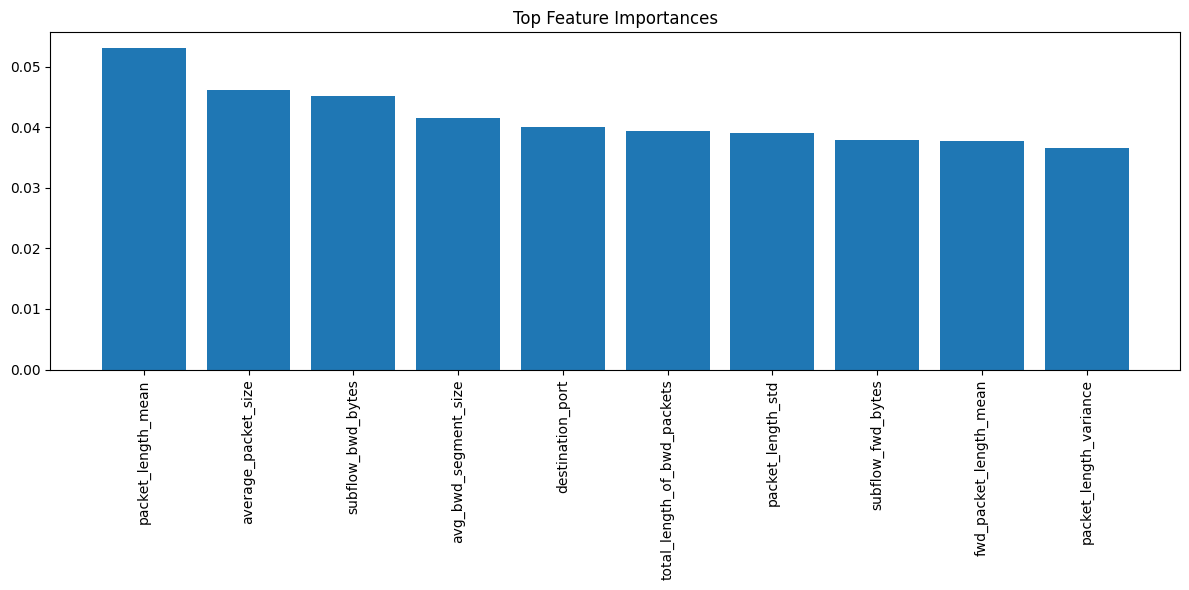

In [46]:
# получаем веса
feature_importances = rf_classifier.feature_importances_

# сортируем
sorted_idx = feature_importances.argsort()[::-1]

# сохраняем названия признаков
feature_names = X_train.columns

# выведем 10 самых значимых признаков
N = 10
for i in range(N):
    print(f"{feature_names[sorted_idx[i]]}: {feature_importances[sorted_idx[i]]}")

# Plot the top N features
plt.figure(figsize=(12, 6))
plt.title("Top Feature Importances")
plt.bar(range(N), feature_importances[sorted_idx][:N], align="center")
plt.xticks(range(N), feature_names[sorted_idx][:N], rotation=90)
plt.tight_layout()
plt.show()

# Общий вывод

В этом проекте была проведена очистка данных, разведочный анализ данных с отбором итоговых признаков, удаление выбросов и масштабирование данных.

Для машинного обучения были рассмотрены модели логистической регрессии с взвешенными классами и апсемплингом (без удаления выбросов), а также модель логистической регрессии, обученная на данных с удаленными выбросами. Также были рассмотрены случайный лес и Catboost Classifier.

Из всех рассмотренных вариантов лучшим оказался Random Forest Classifier с параметрами n_estimators=100, random_state=42, обученная на данных с удаленными выбросами. Взвешенные средние результаты precision, recall, f1-score оказались равны 1.